In [1]:
import simulate_matchings as sims
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from numpy.random import default_rng
rng = default_rng()
np.set_printoptions(precision=2)

In [37]:
def plot_results(data, scale=None, fname=None):
    mean = np.mean(np.diag(data))
    np.fill_diagonal(data, mean)
    norm_data = (data - mean).T
    fig, ax = plt.subplots(dpi=200)
    if scale:
        norm = colors.Normalize(-scale, +scale, clip=True)
    else:
        most = max(np.max(norm_data) - mean, mean - np.min(norm_data))
        norm = colors.Normalize(-most, +most, clip=True)
    ax.set_xticks([0, data.shape[0]-1], ["best", "worst"])
    ax.set_xlabel("course")
    im = ax.imshow(norm_data, cmap='seismic', norm=norm)
    ax.set_ylabel("ranked placement")
    ax.set_yticks([0, data.shape[0]-1], ["first", "last"])
    plt.colorbar(im)

    if fname:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

def plot_match_comparison(data1, data2, match_utilities, course_qualities, fname=None):
    ordering = np.flip(np.argsort(match_utilities))
    width = 0.35
    fig, ax = plt.subplots(dpi=200)
    ax2 = ax.twinx()

    if data2 is not None:
        ax.bar(np.arange(data1.shape[0]) - 0.5 *width, data1[ordering], width, label='original', alpha=0.8)
        ax.bar(np.arange(data2.shape[0]) + 0.5 *width, data2[ordering], width, label='modified', alpha=0.8)
    else:
        ax.bar(np.arange(data1.shape[0]), data1[ordering], 2*width, label='matches', alpha=0.7)
    ax.plot(course_qualities[ordering] / course_qualities.sum(), marker='^', c='tab:red', linestyle='None', label='quality')
    ax2.plot(match_utilities[ordering], marker='o', c='tab:green', linestyle='dashed', label='utility')
    ax.set_xticks([0, data1.shape[0]-1], ["best", "worst"])
    ax.set_xlabel("course")
    ax.set_ylabel("fraction")
    ax.set_ylim(0)
    
    fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

    if fname:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()


In [3]:
def normalize_sum(array):
    return array / np.sum(array)

def normalize_range(array):
    mx, mn = np.max(array), np.min(array)
    return (array - mn) / (mx - mn)

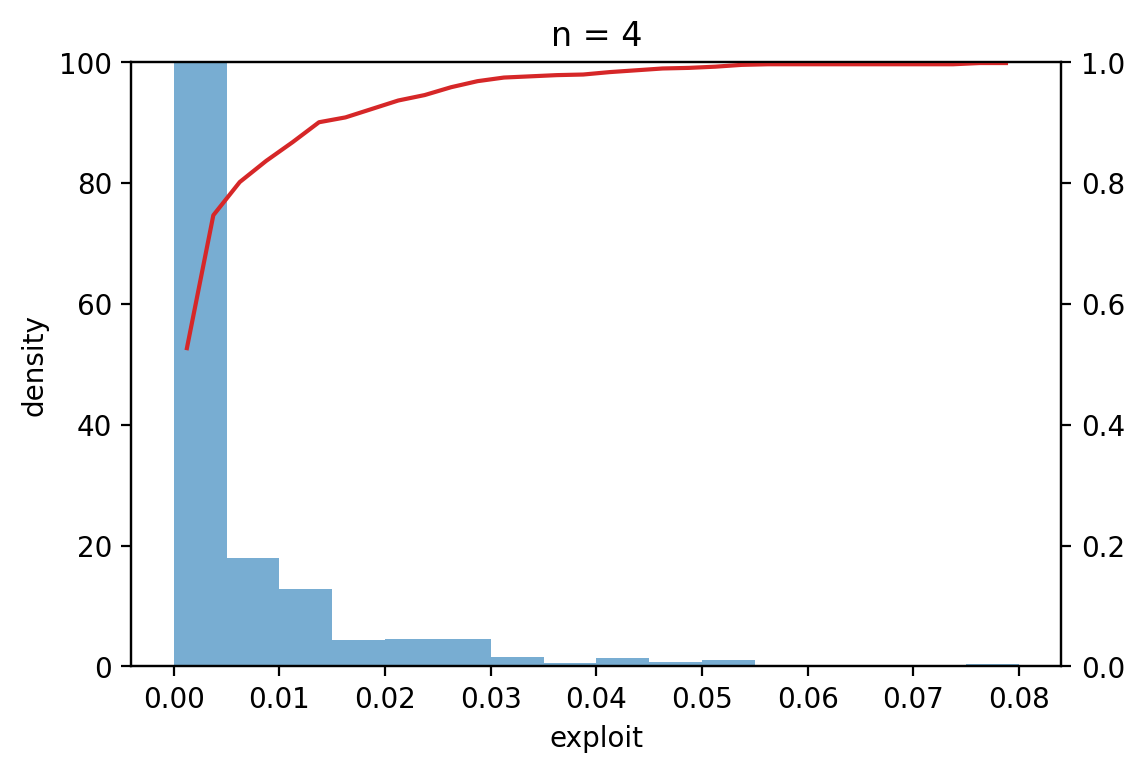

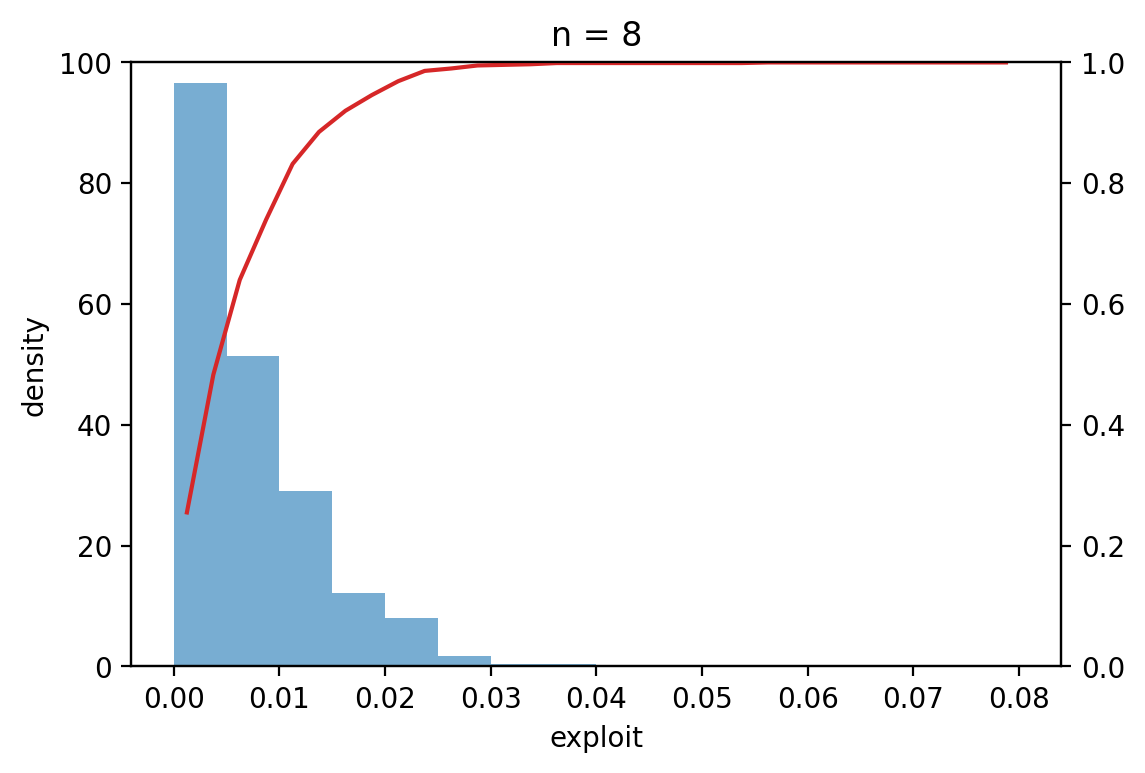

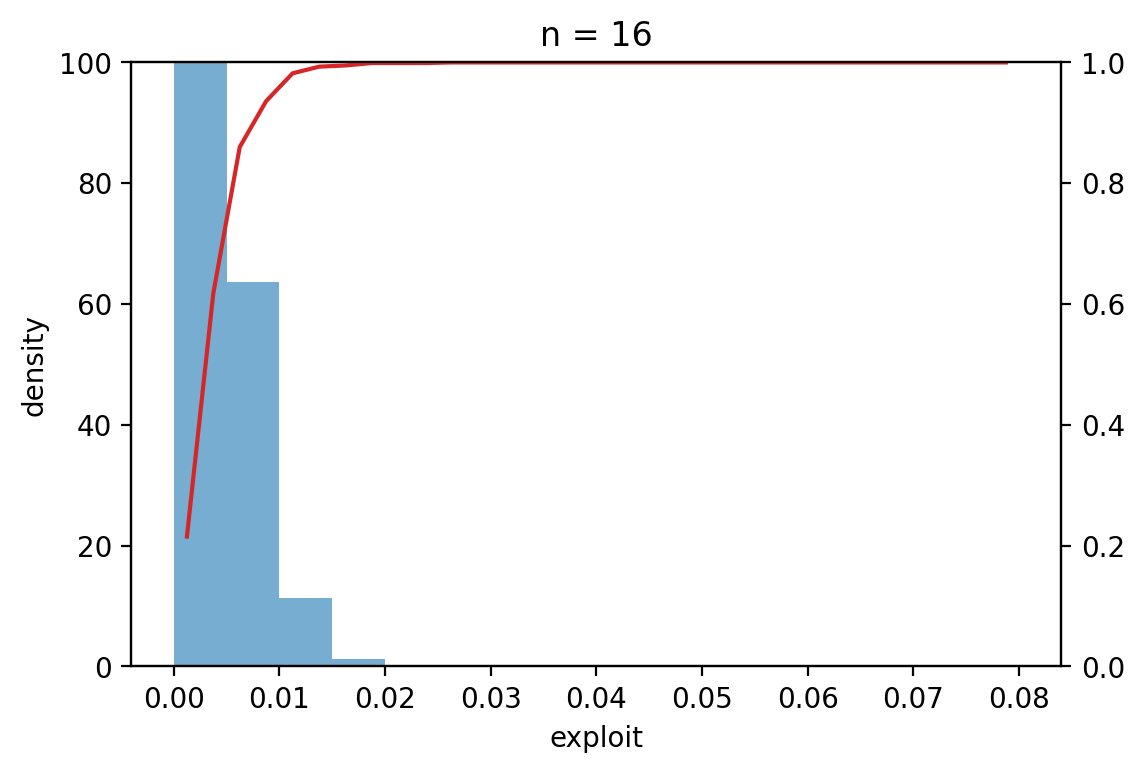

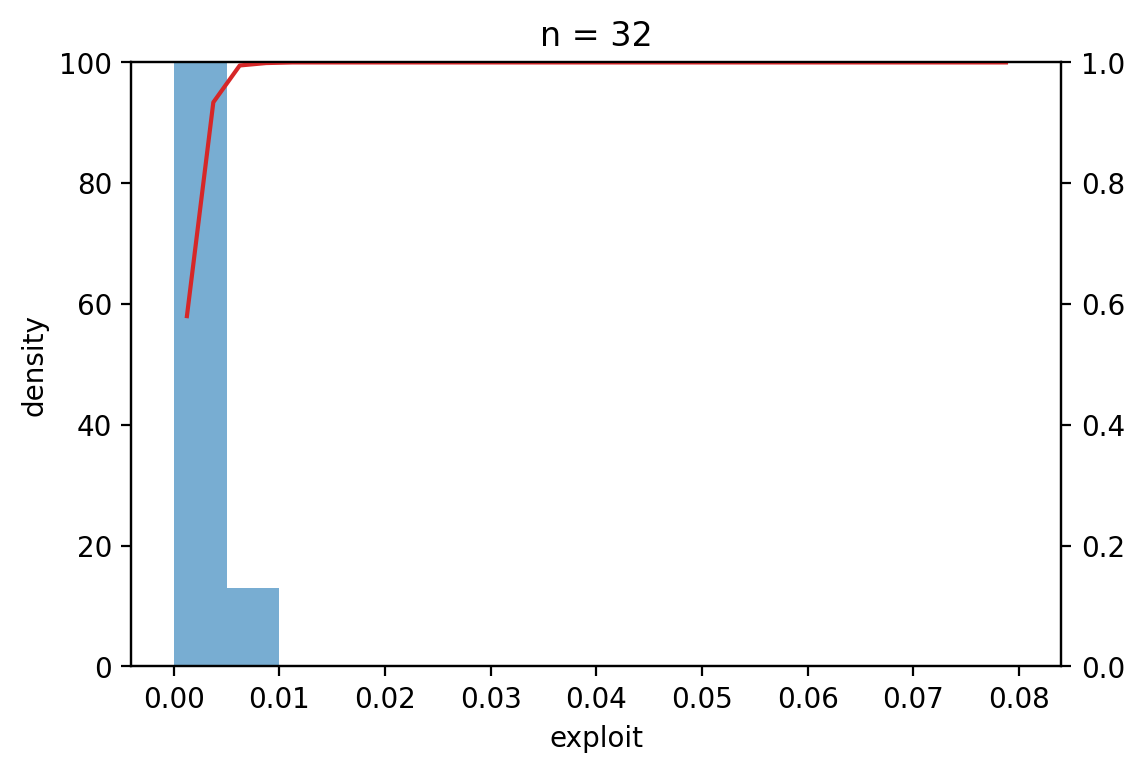

In [128]:
for n in [4, 8, 16, 32]:
    student_weights = course_weights = np.arange(n-1, -1, -1)
    # match_utilities = normalize_range(np.arange(n-1, -1, -1))
    student_qualities = normalize_sum(np.ones(n))
    trials = 1000
    ls_vals = []
    for _ in range(trials):
        course_qualities = normalize_sum(rng.random(n))
        ordering = sims.generate_ordering(course_qualities)
        match_utilities_here = sims.generate_utilities(course_qualities)
        fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 2000)
        results = sims.try_reordering(match_utilities_here, fixed_weights, student_weights)
        ls_vals.append([course_qualities, match_utilities_here, results])
    ls_res = np.array([v[2] for v in ls_vals])

    max_ex = (np.max(ls_res, axis=(1,2)) - np.mean(np.diagonal(ls_res, axis1=1, axis2=2), axis=1))
    hist, bins = np.histogram(max_ex, 32, (0, 0.08))
    cdf = np.cumsum(hist) / 1000
    fig, ax = plt.subplots(dpi=200)
    ax1 = ax.twinx()
    ax.set_title("n = {}".format(n))
    # ax.set_ylim(0)
    ax.set_xlabel("exploit")
    ax.set_ylabel("density")
    ax.hist(max_ex, 16, (0, 0.08), density=True, histtype='stepfilled', alpha=0.6)
    ax1.plot([(bins[i-1]+bins[i])/2 for i in range(1, bins.size)], cdf, color="tab:red")
    ax1.set_ylim((0, 1))
    ax.set_ylim(0, 100)
    plt.savefig("exploit_v_players_exp/{}.png".format(n), bbox_inches='tight')
    plt.show()


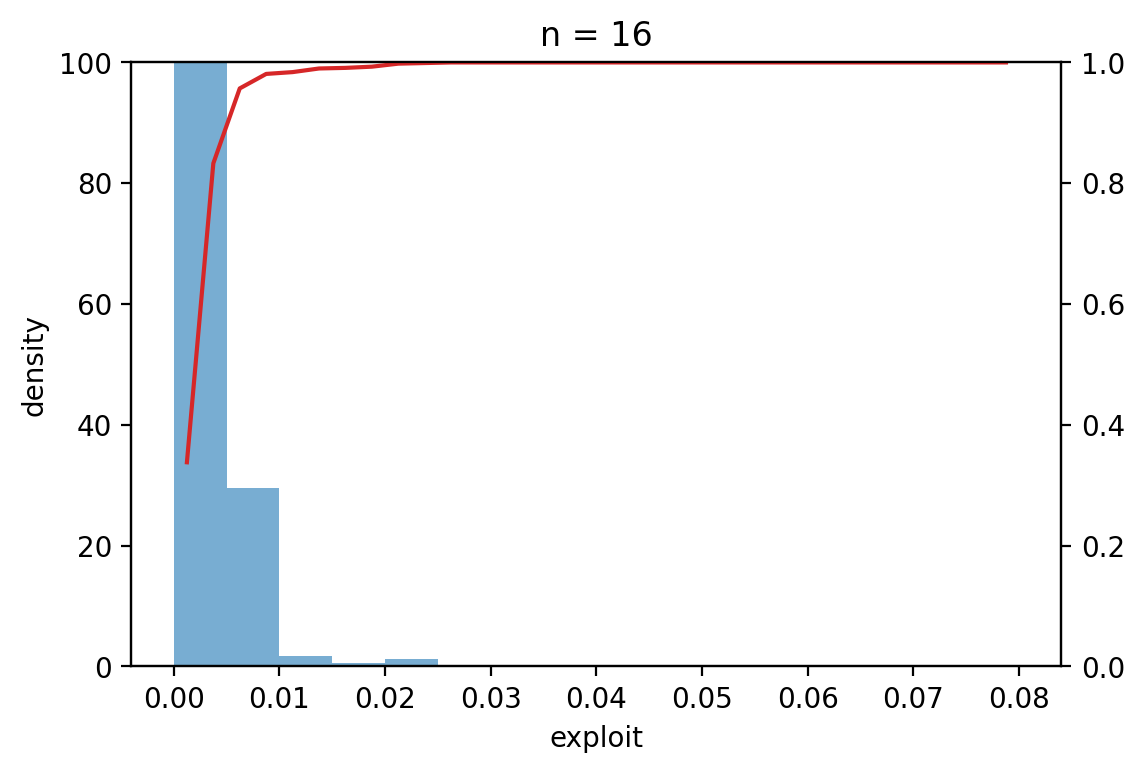

In [126]:
max_ex = (np.max(ls_res, axis=(1,2)) - np.mean(np.diagonal(ls_res, axis1=1, axis2=2), axis=1))
hist, bins = np.histogram(max_ex, 32, (0, 0.08))
cdf = np.cumsum(hist) / 1000
fig, ax = plt.subplots(dpi=200)
ax1 = ax.twinx()
ax.set_title("n = {}".format(n))
# ax.set_ylim(0)
ax.set_xlabel("exploit")
ax.set_ylabel("density")
ax.hist(max_ex, 16, (0, 0.08), density=True, histtype='stepfilled', alpha=0.6)
ax1.plot([(bins[i-1]+bins[i])/2 for i in range(1, bins.size)], cdf, color="tab:red")
ax1.set_ylim((0, 1))
ax.set_ylim(0, 100)
plt.savefig("exploit_v_players_lin/{}.png".format(n), bbox_inches='tight')
plt.show()

In [55]:
index = np.argmax(max_ex)

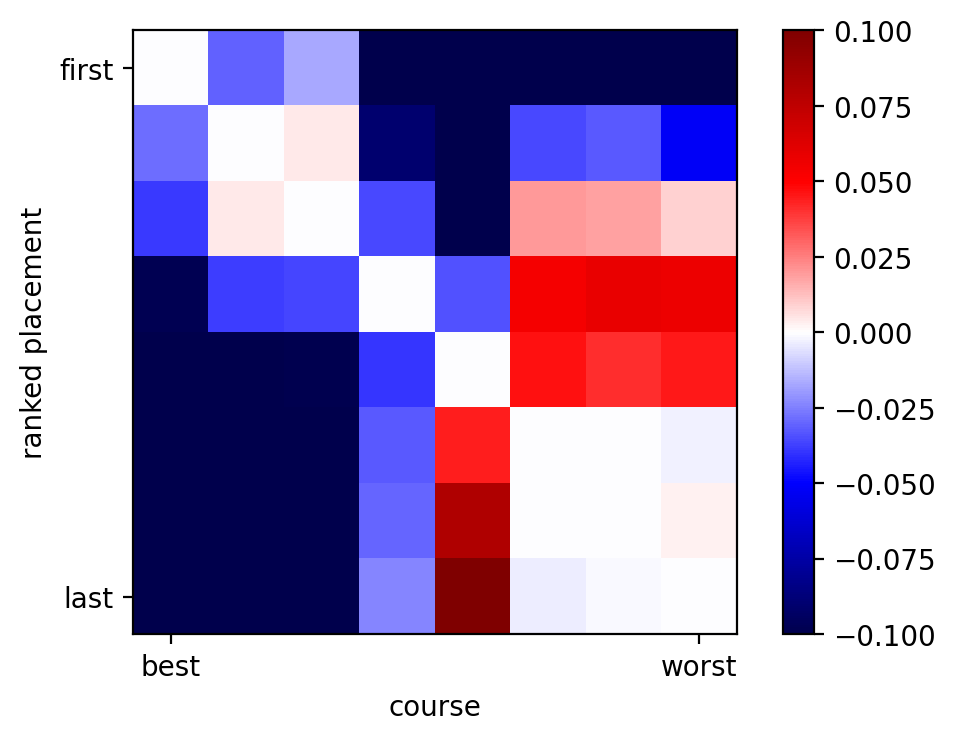

In [56]:
course_qualities, match_utilities, results = ls_vals[index]
plot_results(ls_res[index], 0.1)

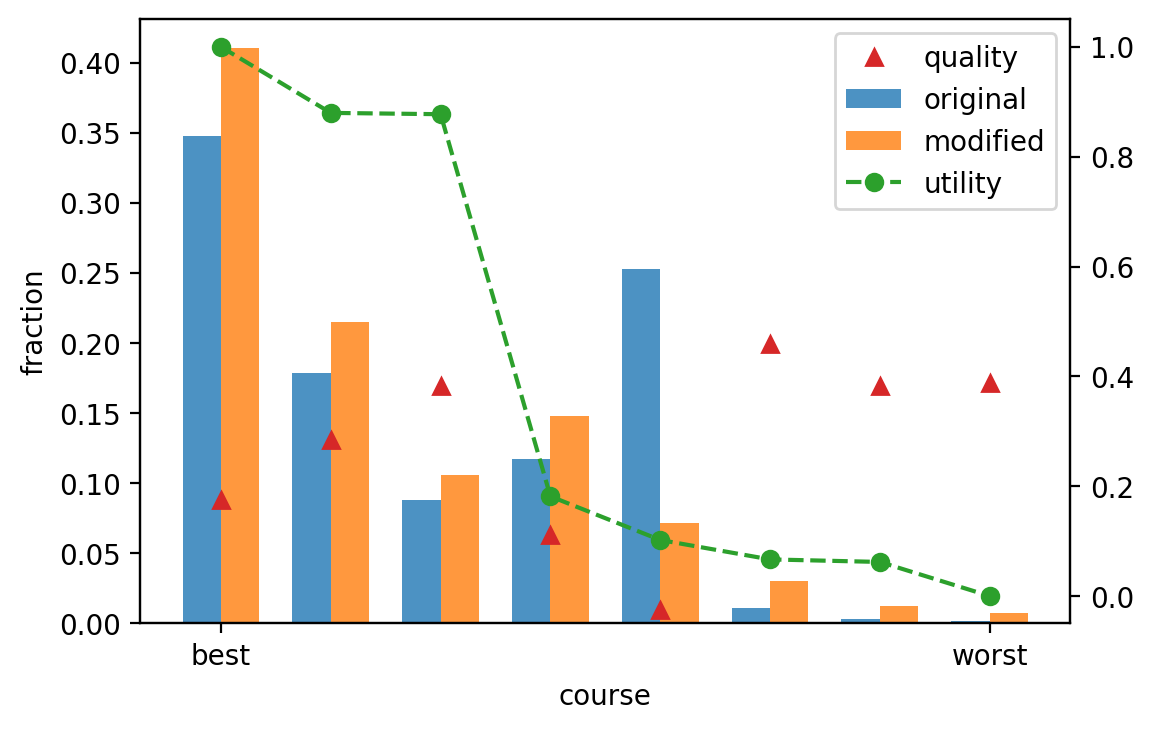

In [57]:
default_ranking = sims.default_ranking(match_utilities)
fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
new_matches = sims.match_results(sims.reorder_ranking(default_ranking, 4, 7), fixed_weights, student_weights)
plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities, course_qualities)

In [45]:
max_ex[601]

0.332914654508674

In [53]:
print(sims.avg_utility(match_utilities, init_matches))
print(sims.avg_utility(match_utilities, new_matches))

0.17254368747751272
0.2264742929884645


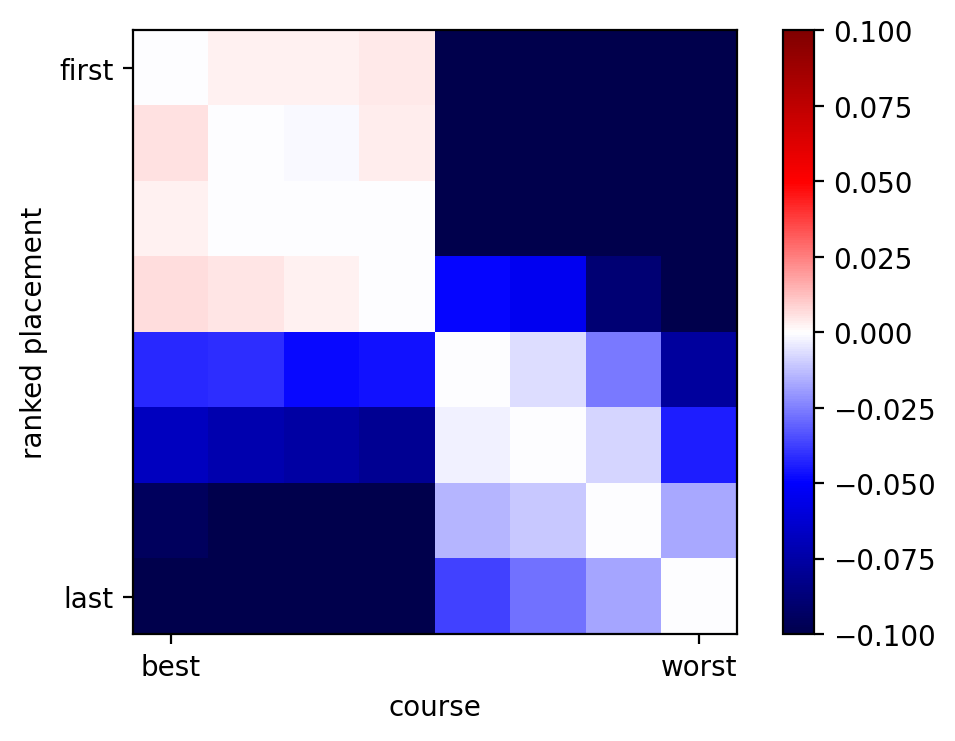

In [110]:
n = 8
student_qualities = normalize_sum(np.ones(n))
course_qualities = normalize_sum(np.array([1, 2, 3, 4, 5, 6, 7, 8]))
student_weights = course_weights = np.arange(n-1, -1, -1)

fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
match_utilities = normalize_range(np.array([0, 0.1, 0.2, 0.3, 10, 10.1, 10.2, 10.3]))
results = sims.try_reordering(match_utilities, fixed_weights, student_weights)
plot_results(results, 0.1)

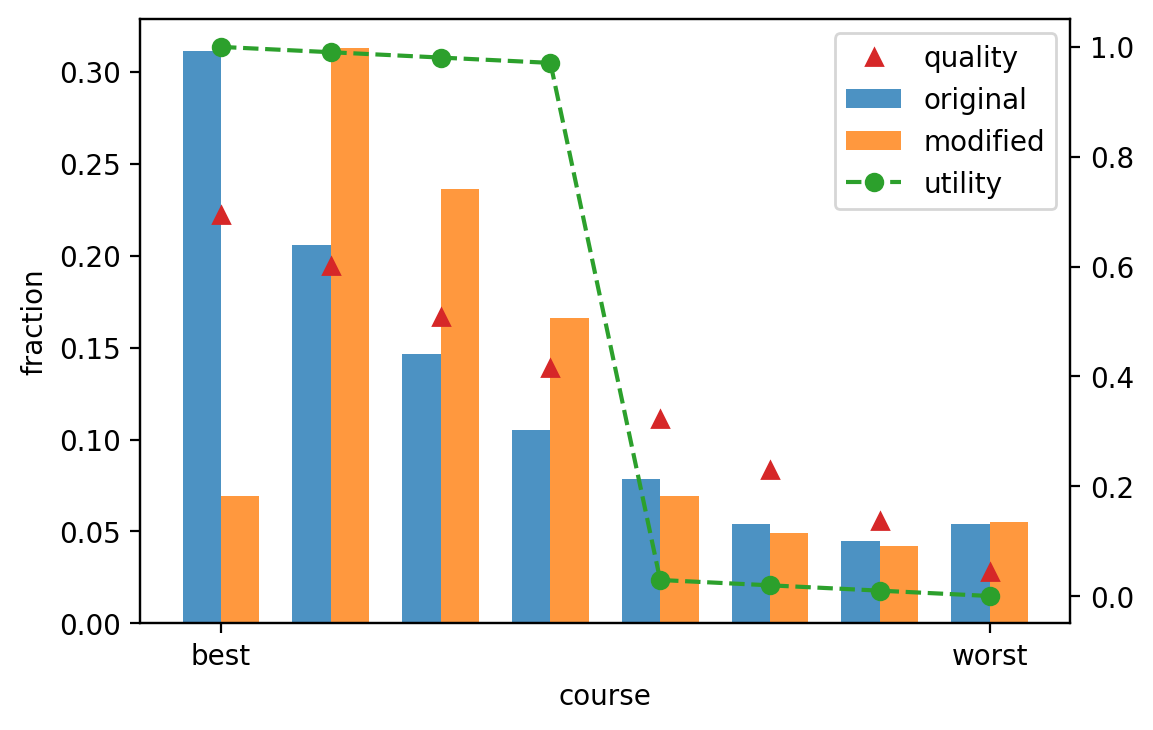

In [111]:
default_ranking = sims.default_ranking(match_utilities)
init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
new_matches = sims.match_results(sims.reorder_ranking(default_ranking, 0, 3), fixed_weights, student_weights)
plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities, course_qualities)

In [130]:
print(sims.avg_utility(match_utilities, init_matches))
print(sims.avg_utility(match_utilities, new_matches))

0.19672173830641115
0.19871558229928152


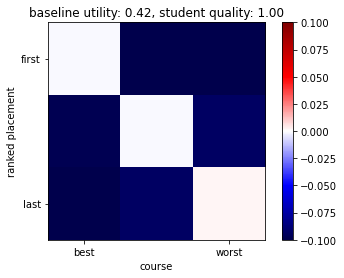

In [134]:
n = 3
student_qualities = np.ones(n)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(n)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(n-1, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
match_utilities = match_utilities / np.sum(match_utilities)
results = sims.try_reordering(match_utilities, fixed_weights, student_weights)
plot_results(results, student_qualities, 0.1)

(array([[  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  1.,   1.,   4.,   1.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  1.,   4.,   2.,   8.,   6.,   2.,   0.,   2.,   0.,   0.,   0.,
           0.],
        [  3.,   9.,  12.,  11.,  13.,   4.,   7.,   2.,   1.,   0.,   0.,
           0.],
        [ 10.,  33.,  41.,  46.,  94.,  34.,  30.,   9.,   9.,   0.,   0.,
           0.],
        [  5.,  40.,  75., 129., 137.,  82.,  83.,  12.,   7.,   1.,   0.,
           0.],
        [  7.,  25.,  40., 118., 126.,  84., 153.,  53.,  17.,  11.,   0.,
           0.],
        [  5.,  29.,  46.,  93., 176., 156., 137., 118.,  80.,  30.,   5.,
           0.],
        [  0.,   7.,  56., 122., 149., 187., 257., 135., 101.,  76.,   2.,
           0.],
        [  0.,   0.,   7.,  49.,  70.,  53., 167.,  82.,  53.,  68.,  18.,
           1.],
        [  0.,   0.,   0.,  21.,  65.,  63.,  71., 114.,  73.,  29.,  22.,
           0.],

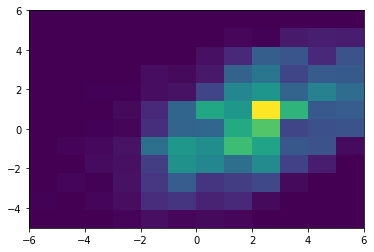

In [144]:
vals = fixed_weights - fixed_weights[:, 0][:, np.newaxis]
plt.hist2d(vals[:, 1], vals[:, 2], bins=12)

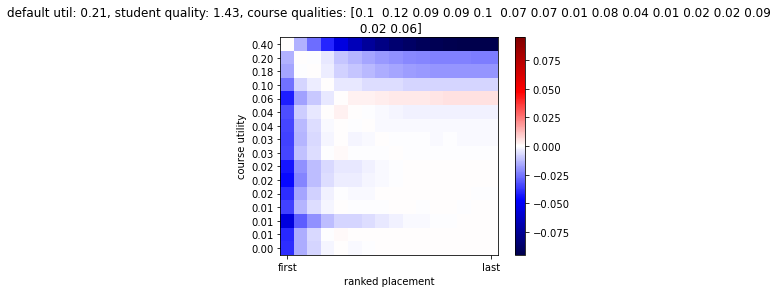

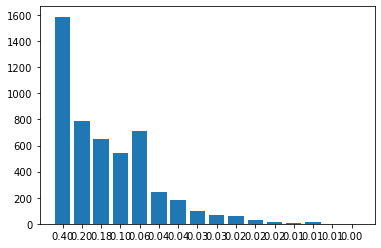

KeyboardInterrupt: 

In [ ]:
n = 16
for _ in range(3):
    student_qualities = rng.random(n)
    student_qualities /= np.sum(student_qualities)
    course_qualities = rng.random(n)
    course_qualities /= np.sum(course_qualities)
    student_weights = course_weights = np.arange(n-1, -1, -1)
    match_utilities = sims.generate_utilities(course_qualities)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    matches = sims.match_results(sims.default_ranking(match_utilities), fixed_weights, student_weights)
    results1 = sims.try_reordering(match_utilities, fixed_weights, student_weights)
    plot_results(results1, student_qualities, 0.1)
    plot_matches(np.histogram(matches, bins=n)[0], match_utilities)

In [ ]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
results2 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)


In [ ]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
results3 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)

In [ ]:
student_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results4 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

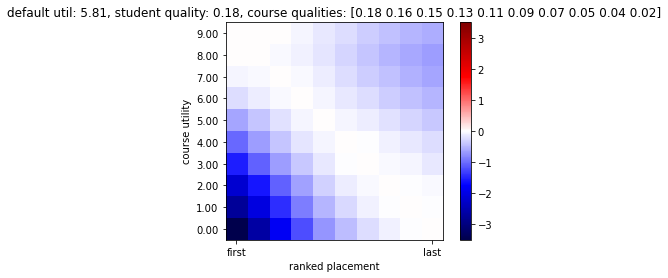

In [ ]:
plot_results(results4)

In [ ]:
student_qualities = np.arange(1, 11)
student_qualities[0] = 30
student_qualities = np.divide(student_qualities, np.sum(student_qualities))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results5 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

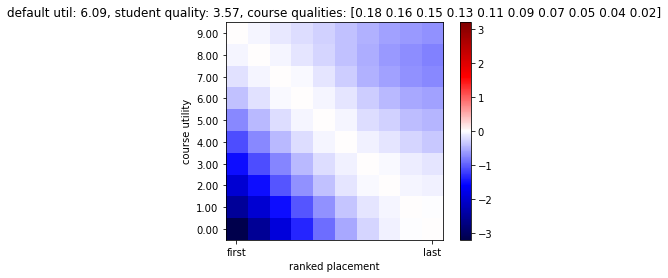

In [ ]:
plot_results(results5)

In [114]:
# other students, constant quality
n = 16
course_qualities = normalize_sum(np.arange(1, n + 1))
student_weights = course_weights = np.arange(n-1, -1, -1)
match_utilities = normalize_range(np.arange(n))
ranking = sims.default_ranking(course_qualities)

qualities = np.logspace(-9, -0.001, 20, base=np.e)
results = []
for q in qualities:
    student_qualities = np.zeros(n)
    student_qualities[0] = q
    student_qualities[1:] = (1 - q) / (n - 1)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    res = sims.avg_utility(match_utilities, sims.match_results(ranking, fixed_weights, student_weights))
    results.append(res)

In [124]:
# randomize course ordering
n = 16
course_qualities = normalize_sum(np.arange(1, n + 1))
student_weights = course_weights = np.arange(n-1, -1, -1)

qualities = np.logspace(-9, -0.001, 20, base=np.e)
results2 = []
for q in qualities:
    student_qualities = np.zeros(n)
    student_qualities[0] = q
    student_qualities[1:] = (1 - q) / (n - 1)
    res = 0
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 6000)
    for i in range(2000):
        ordering = sims.generate_ordering(course_qualities)
        match_utilities = normalize_range(course_qualities[np.argsort(ordering)])
        ranking = sims.default_ranking(match_utilities)
        res += sims.avg_utility(match_utilities, sims.match_results(ranking, fixed_weights, student_weights))
    results2.append(res / 2000)

array([15, 14,  8, 13, 12,  9,  2,  1, 11,  3,  6,  4,  7, 10,  5,  0])

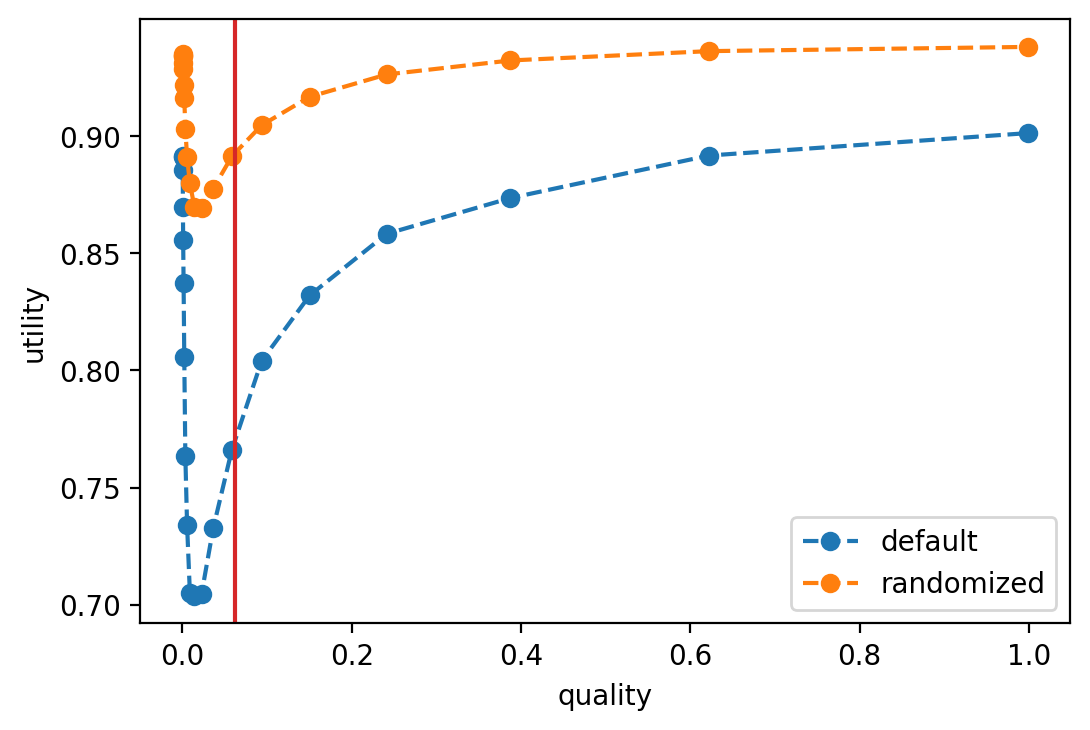

In [125]:
plt.figure(dpi=200)
plt.plot(qualities, results, marker='o', linestyle='dashed', label='default')
plt.plot(qualities, results2, marker='o', linestyle='dashed', label='randomized')
plt.legend()
plt.ylabel("utility")
plt.xlabel("quality")
plt.axvline(x=1/n, ymin=0, ymax=1, color='tab:red')
plt.show()

In [179]:
results[-2]

0.06788920833333342

In [165]:
# other students, linear quality
n = 16
course_qualities = np.arange(1, n + 1) / np.sum(np.arange(1, n + 1))
student_weights = course_weights = np.arange(n-1, -1, -1)
match_utilities = course_qualities
ranking = student_weights

qualities = np.logspace(-9, -0.001, 20, base=np.e)
results = []
for q in qualities:
    student_qualities = np.arange(n, dtype=float)
    student_qualities[0] = q
    student_qualities[1:] *= 2 * (1 - q) / ((n - 1) * n)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    res = sims.avg_utility(match_utilities, sims.match_results(ranking, fixed_weights, student_weights))
    results.append(res)

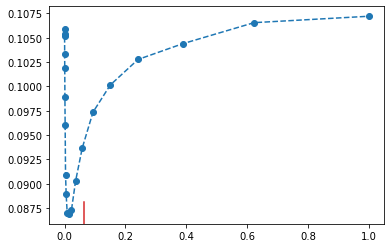

In [169]:
plt.axvline(x=1/n, ymin=-0.1, ymax=0.1, color='tab:red')
plt.plot(qualities, results, marker='o', linestyle='dashed')
plt.show()

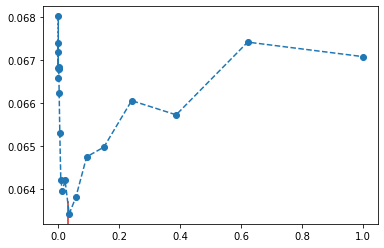

In [243]:
plt.axvline(x=1/n, ymin=0, ymax=0.1, color='tab:red')
plt.plot(qualities, results, marker='o', linestyle='dashed')
plt.show()

As quantity approaches 1, utility gets worst.

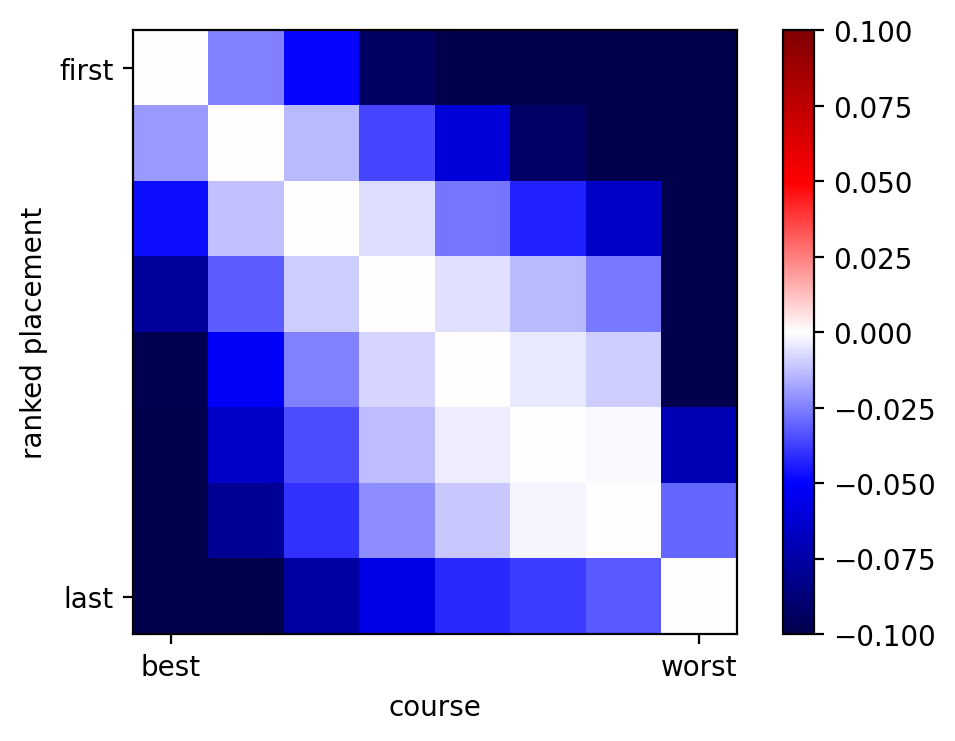

0.729225


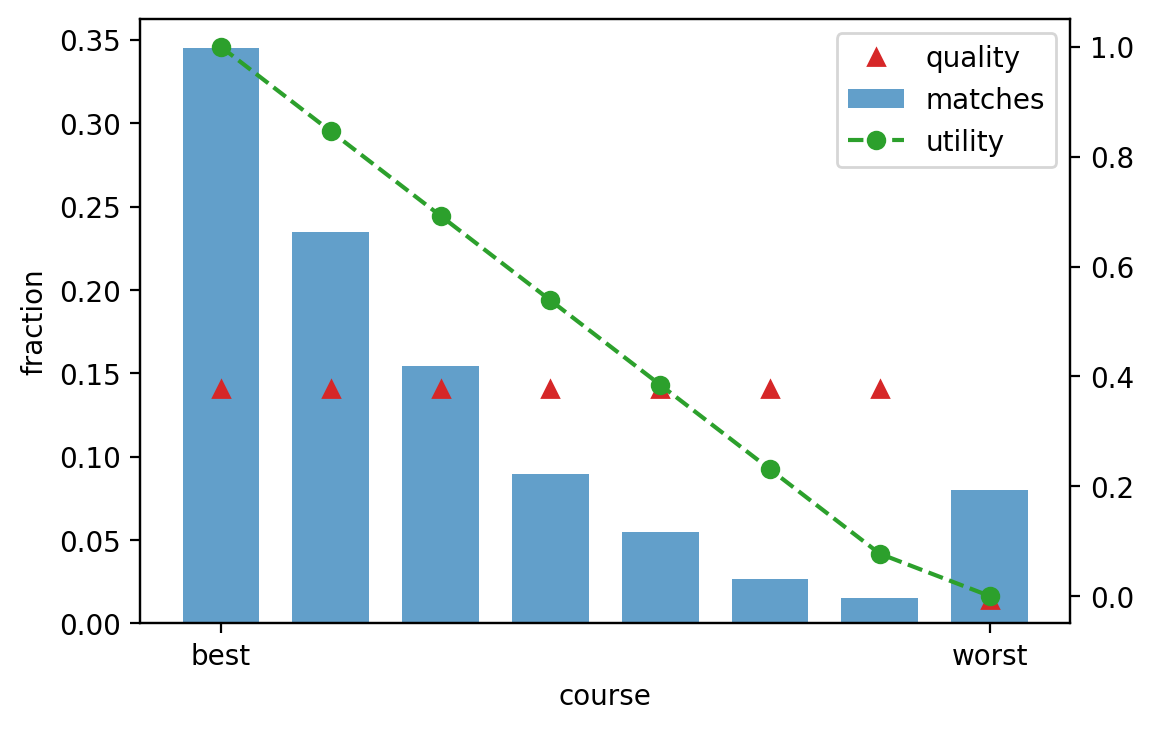

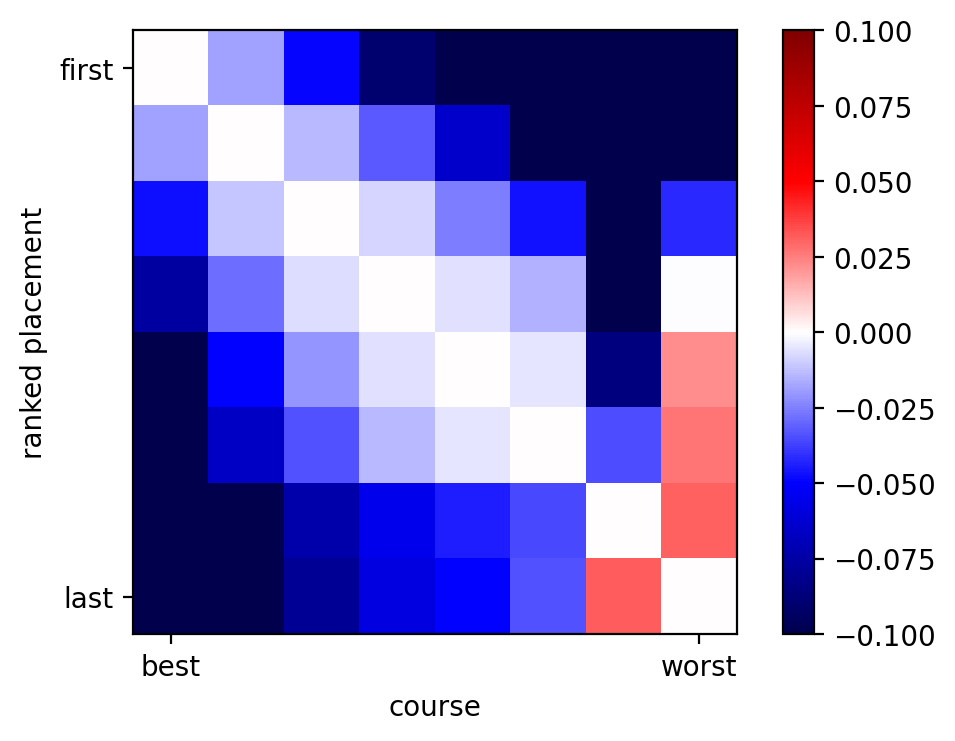

0.6950062499999999


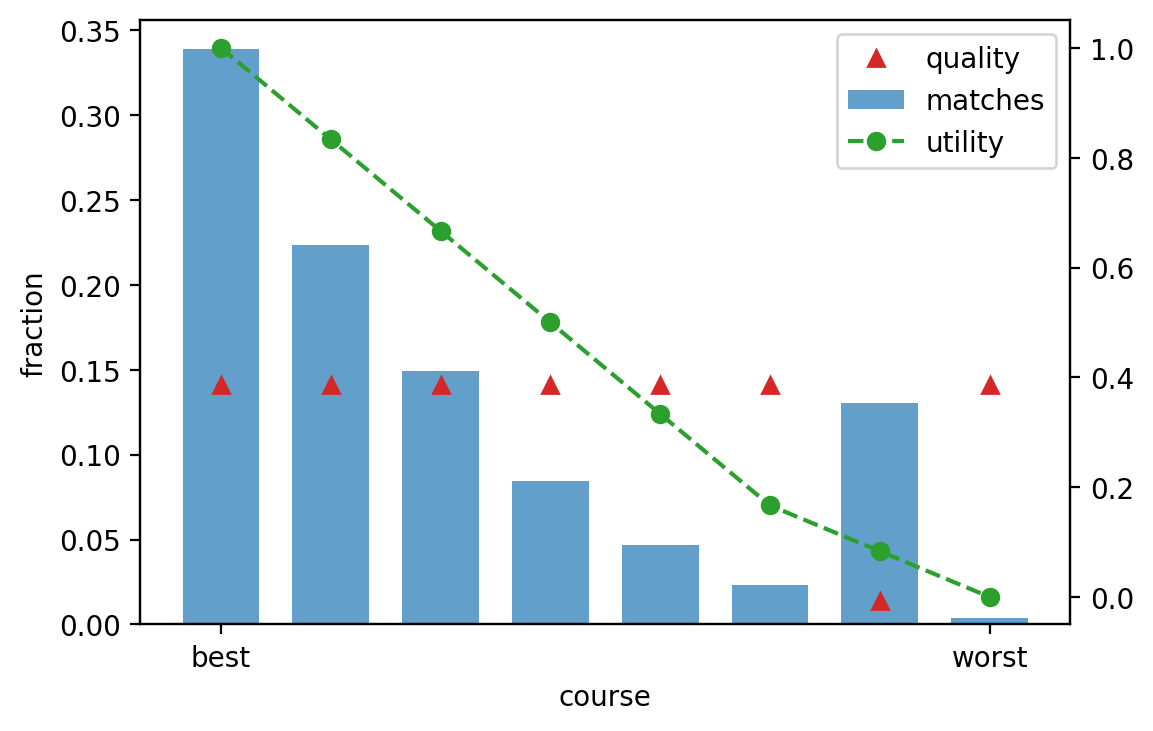

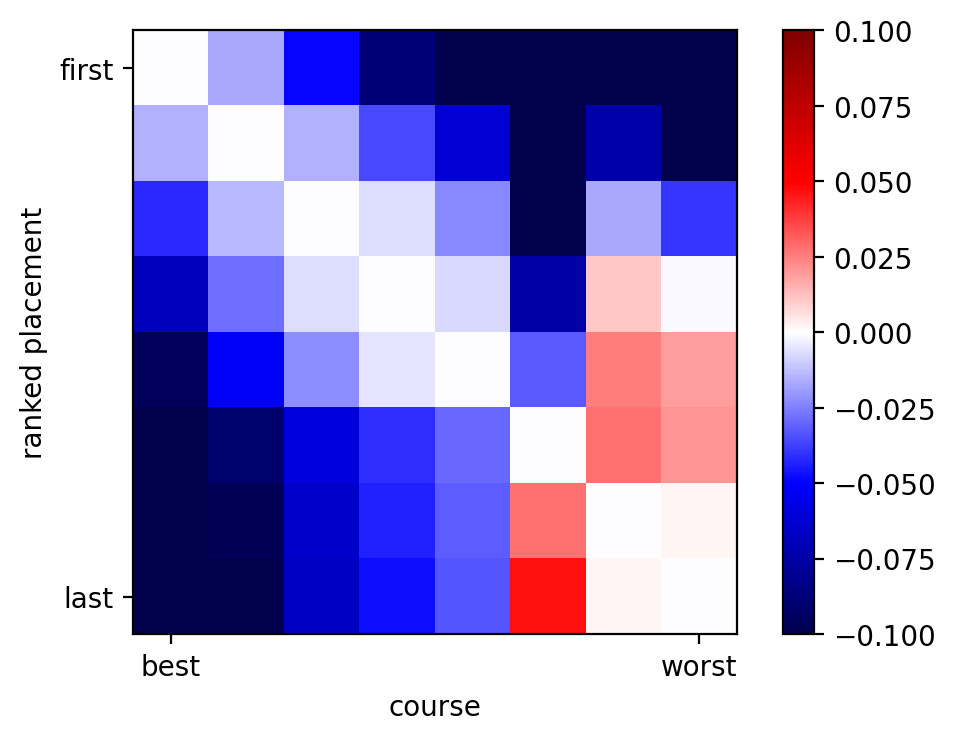

0.6893208333333334


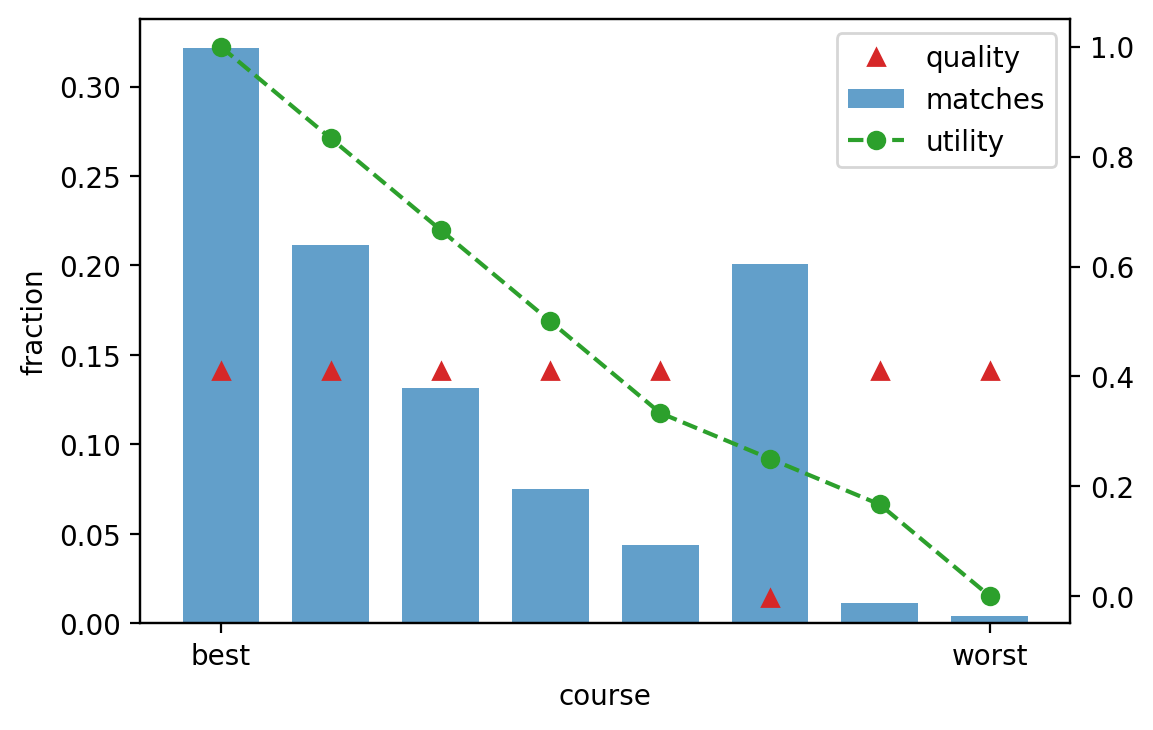

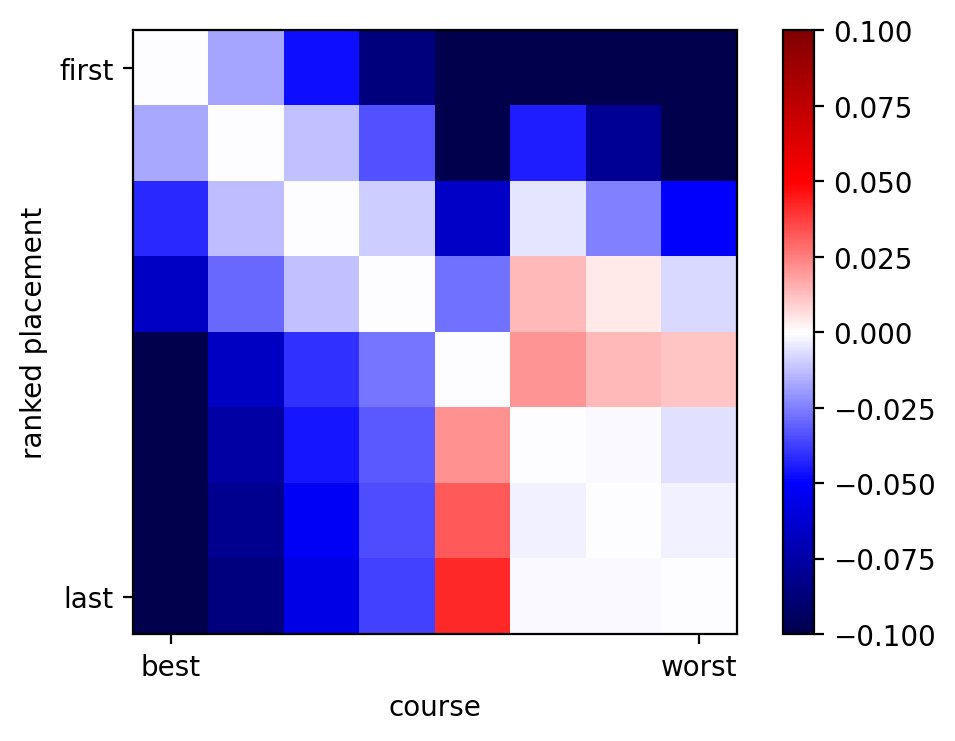

0.7034125


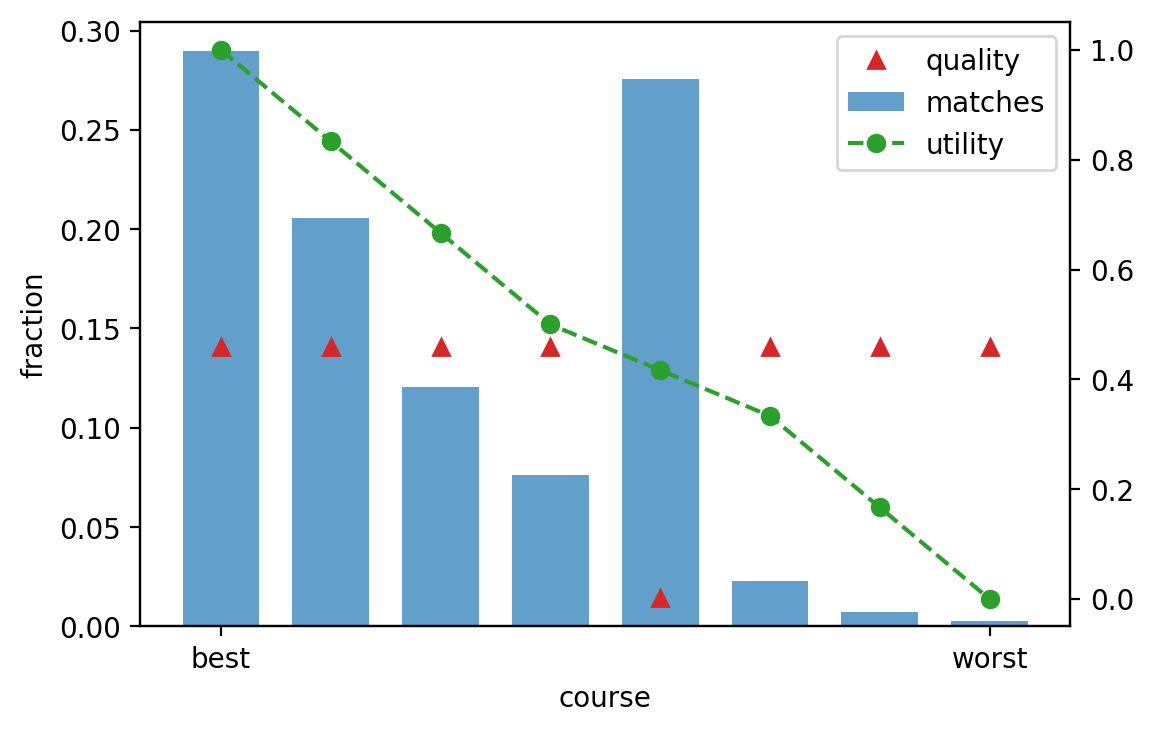

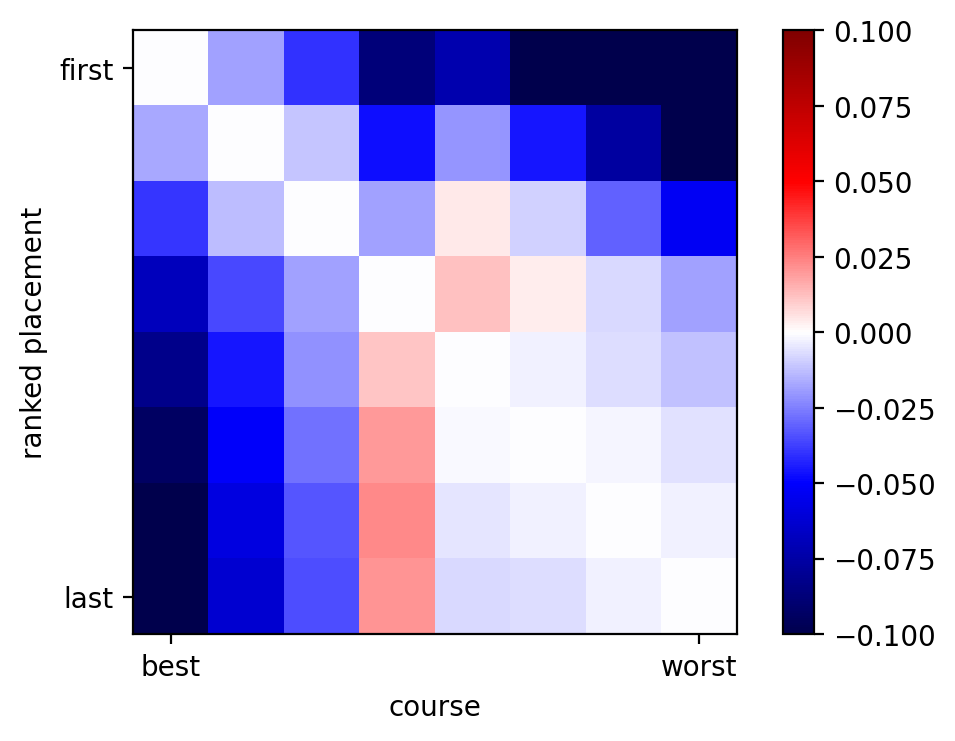

0.7395354166666666


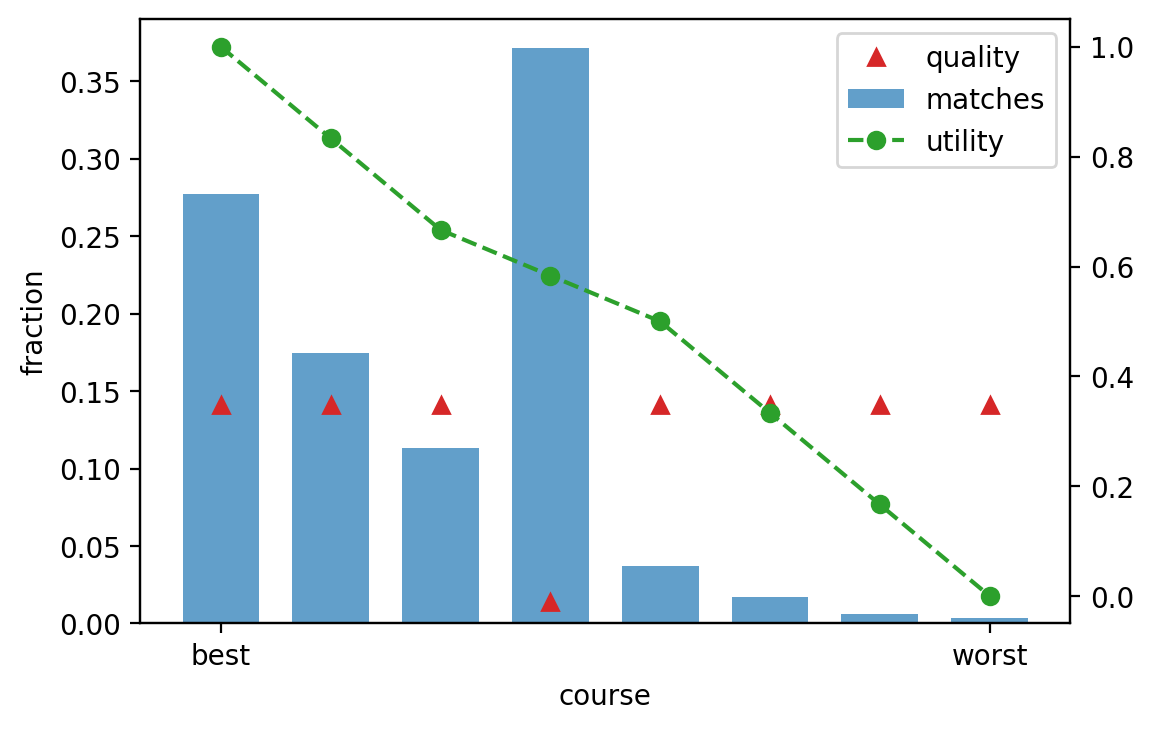

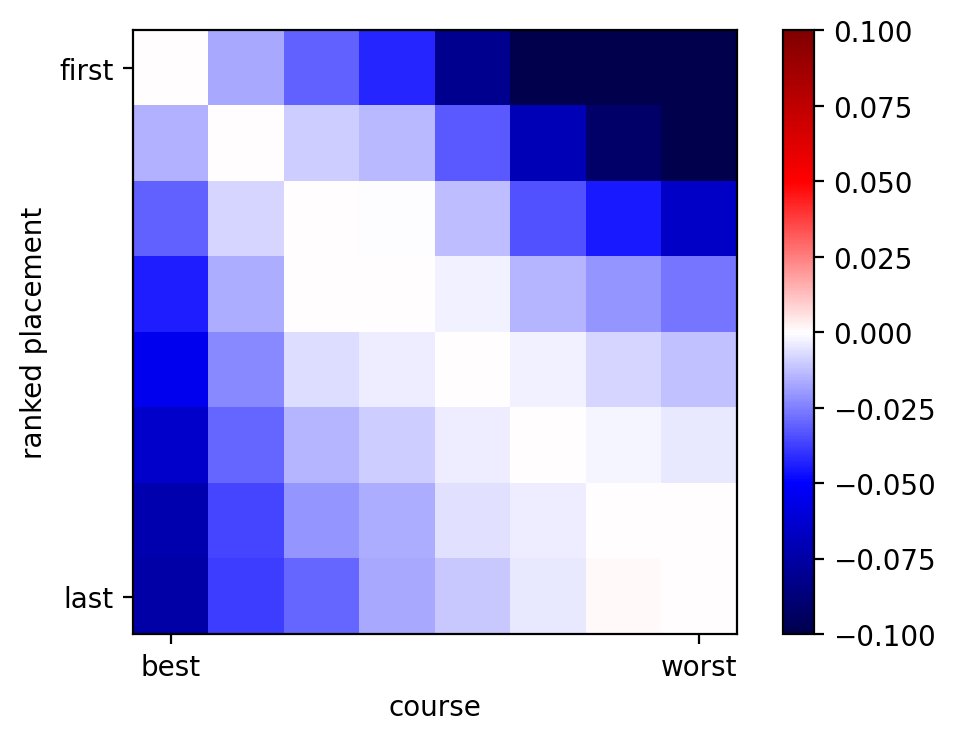

0.79985625


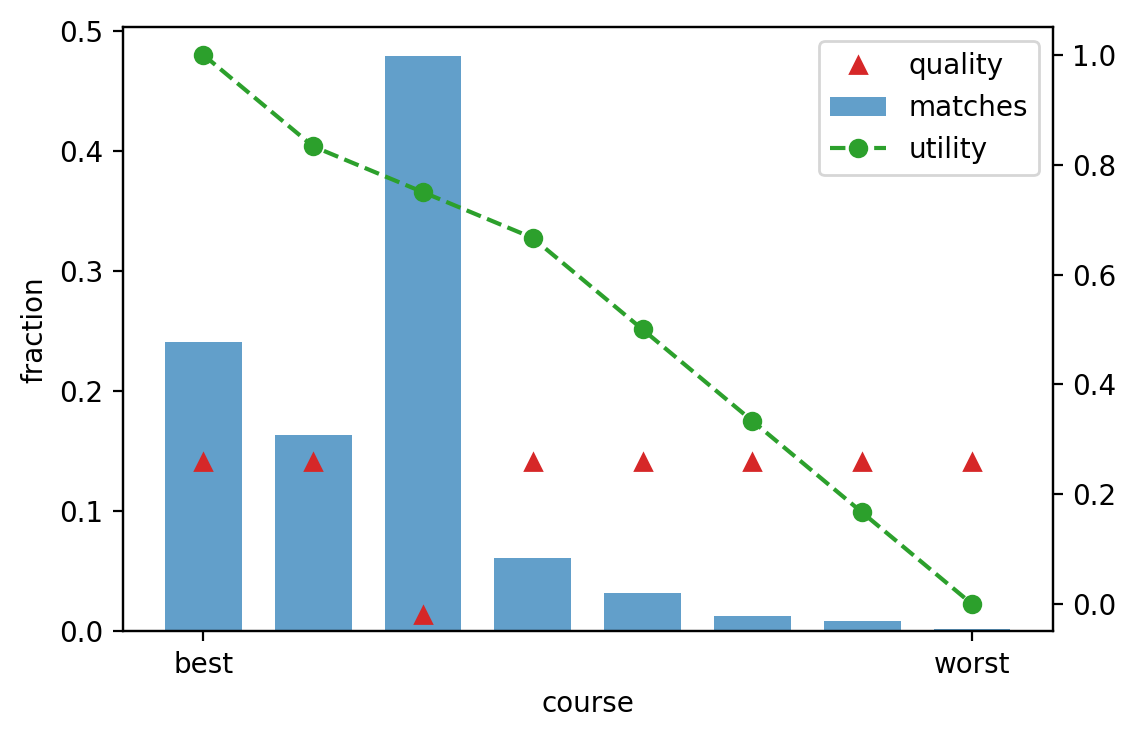

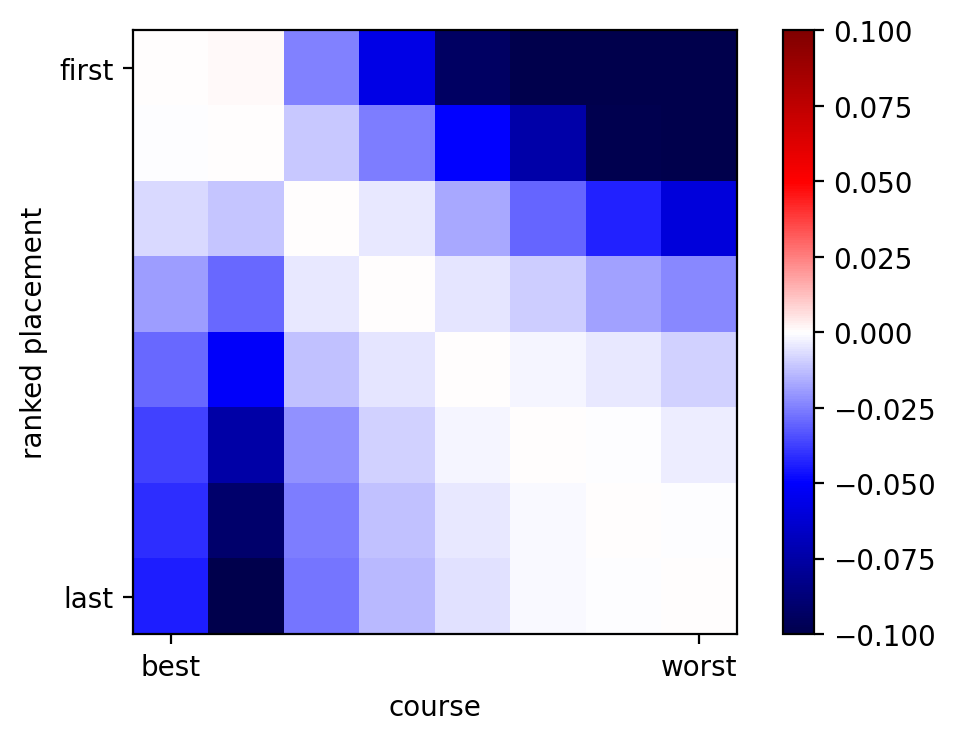

0.8936187500000001


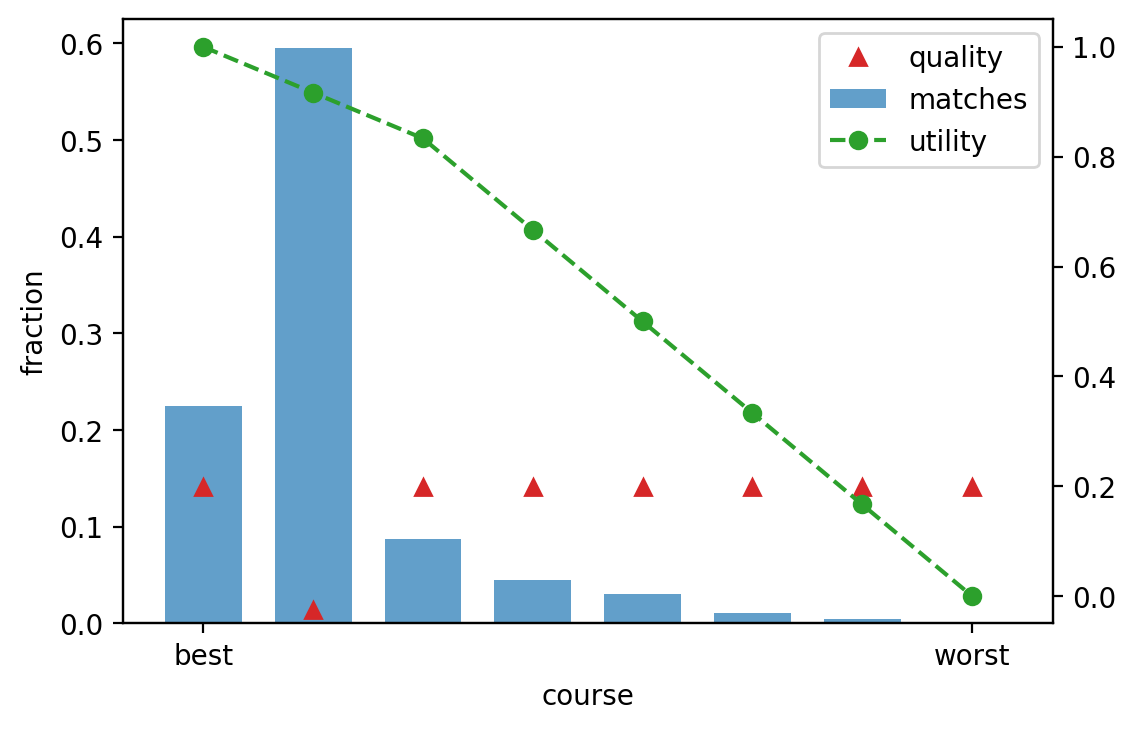

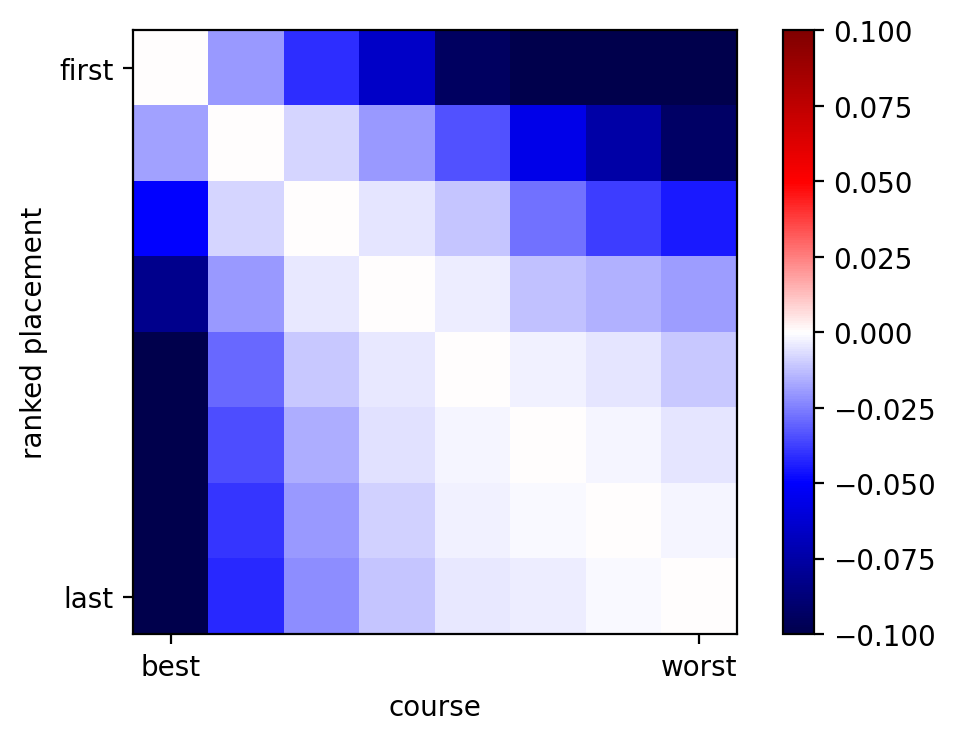

0.9356269230769231


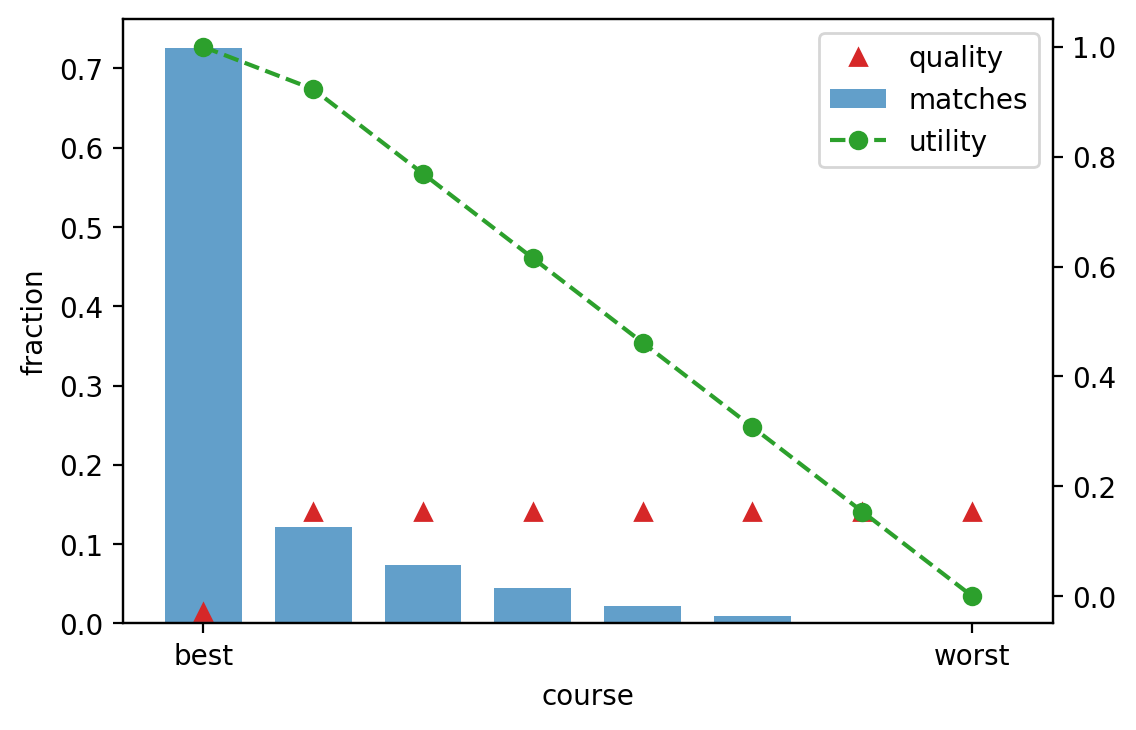

In [112]:
# checking if there is a dud course that you like to varying degrees
n = 8
student_qualities = np.ones(n) / n
student_weights = course_weights = np.arange(n-1, -1, -1)
course_qualities = np.ones(n)
course_qualities[0] = 0.1
course_qualities = normalize_sum(course_qualities)

for w in np.linspace(0.5, n-0.5, n):
    match_utilities = np.arange(n, dtype=float)
    match_utilities[0] = w
    match_utilities = normalize_range(match_utilities)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    res = sims.try_reordering(match_utilities, fixed_weights, student_weights)
    plot_results(res, scale=0.1, fname="dud_course/{}.png".format(n-int(w)))
    print(res[0, 0])
    default_ranking = sims.default_ranking(match_utilities)
    init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
    # new_matches = sims.match_results(sims.reorder_ranking(default_ranking, n-1-int(w), n-1), fixed_weights, student_weights)
    plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, None, match_utilities, course_qualities, fname="dud_course/{}bar.png".format(n-int(w)))